In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.utils.data as data_utils

In [2]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060'

# Prep and Definitions

## Class to Prepare Data

In [173]:
# Define Data Builder
class build_data(BaseEstimator, TransformerMixin):
    """
    Loads and Prepares dataset for pytorch
    WMAE weights are last two values in y"""
    
    def __init__(self, df, drop, split_size=0.33, rand=22391, batch=1, shuffle=True, pin=True, ts_only=True, wt=True):
        self.wt = wt
        self.rand = rand
        self.split_size = split_size
        self.batch = batch
        self.shuffle = shuffle
        self.pin = pin
        self.ts = ts_only
        
        if pin:
            print('If pin==True the data cannot be preloaded into GPU, cuda must be False when fitting')
        
        df = df.astype('float')
        
        ccols = [i for i in df.columns if 'Feature' in i]
        self.keep = [i for i in ccols if i not in drop]
        
        self.x = df.iloc[:,26:147] # time steps
        self.x2 = df.loc[:,self.keep] # other features
        self.y = df.iloc[:,147:]
               
    def _na_fill(self,mode):
        for i in self.x2.columns:
            if i in mode:
                self.x2[i] = self.x2[i].fillna(value=self.x2[i].mode()[0])
            else:
                self.x2[i] = self.x2[i].fillna(value=self.x2[i].median())
                
        self.x = self.x.interpolate(method='linear', axis=1)
        self.x_fin = pd.concat([self.x2,self.x], axis=1)
        
    def _split(self):
        X_train, X_test, y_train, y_test = train_test_split(self.x_fin, self.y, test_size=self.split_size, random_state=self.rand)

        # Seperate Features and TS
        self.X_train_ts = X_train.iloc[:,23:147]
        self.X_test_ts = X_test.iloc[:,23:147]

        self.X_train_ft = X_train.iloc[:,:23]
        self.X_test_ft = X_test.iloc[:,:23]

        # Get Weights for MAE
        # Weights also included in loader, be sure to index when running
        self.test_wt, self.train_wt = np.asarray(y_test.iloc[:,-2:]), np.asarray(y_train.iloc[:,-2:])
        self.y_test, self.y_train = np.asarray(y_test.iloc[:,:-2]), np.asarray(y_train.iloc[:,:-2])
        
    def _scale(self,stsc,lab,dev=True):
        ctrans =  ColumnTransformer(
                    [('scale_all', StandardScaler(), stsc),
                     ('cats', OneHotEncoder(categories='auto'), lab)])
        
        xtsc = StandardScaler()
        ytsc = StandardScaler()
       # mmx = MinMaxScaler(feature_range=(-1,1))
       # mmy = MinMaxScaler(feature_range=(-1,1))
        wtsc = StandardScaler(with_mean=False)
        
        self.X_train_ft = ctrans.fit_transform(self.X_train_ft)
        self.X_test_ft = ctrans.transform(self.X_test_ft)
        self.X_train_ts = xtsc.fit_transform(self.X_train_ts)
        self.X_test_ts = xtsc.transform(self.X_test_ts)
        
     #   self.X_train_ts = mmx.fit_transform(self.X_train_ts)
     #   self.X_test_ts = mmx.transform(self.X_test_ts)
        
        
        if self.ts:
            self.x_train = self.X_train_ts
            self.x_test = self.X_test_ts
        else:
            self.x_train = np.concatenate([self.X_train_ft, self.X_train_ts], axis=1)
            self.x_test = np.concatenate([self.X_test_ft, self.X_test_ts], axis=1)
        
        self.train_wt = wtsc.fit_transform(self.train_wt)
        self.test_wt = wtsc.transform(self.test_wt)
        
        self.y_train_sc = ytsc.fit_transform(self.y_train)
        self.y_test_sc = ytsc.transform(self.y_test)
      #  self.y_train_sc = mmy.fit_transform(self.y_train_sc)
      #  self.y_test_sc = mmy.transform(self.y_test_sc)
        
        if self.wt:
            self.y_train = np.concatenate([self.y_train,self.train_wt],axis=1)
            self.y_test = np.concatenate([self.y_test,self.test_wt],axis=1)
        
        self.xtrans_sc = xtsc
      #  self.xtrans_mm = mmx
      #  self.ytrans_mm = mmy
        self.ytrans_sc = ytsc
        self.ftrans = ctrans
        
    def fit(self, mode, stsc, lab, cuda=False):
        self._na_fill(mode)
        self._split()
        self._scale(stsc,lab)
        self.mode = mode
        
        torch_x_train, torch_y_train = torch.from_numpy(self.x_train).float(), torch.from_numpy(self.y_train_sc).float()
        torch_x_test, torch_y_test = torch.from_numpy(self.x_test).float(), torch.from_numpy(self.y_test_sc).float()

        
        if cuda:
            torch_x_train, torch_x_test = torch_x_train.view(-1,1,121).cuda(), torch_x_test.view(-1,1,121).cuda()
            torch_y_train, torch_y_test = torch_y_train.view(-1,1,62).cuda(), torch_y_test.view(-1,1,62).cuda()
        else:
            torch_x_train, torch_x_test = torch_x_train.view(-1,1,121), torch_x_test.view(-1,1,121)
            torch_y_train, torch_y_test = torch_y_train.view(-1,1,62), torch_y_test.view(-1,1,62)
        
        train = data_utils.TensorDataset(torch_x_train, torch_y_train)
        test = data_utils.TensorDataset(torch_x_test, torch_y_test)

        
        train_loader = data_utils.DataLoader(train, batch_size=self.batch, shuffle=self.shuffle, pin_memory=self.pin)
        test_loader = data_utils.DataLoader(test, batch_size=self.batch, shuffle=self.shuffle, pin_memory=self.pin)
        
        return train_loader, test_loader
    
    def fit_sub(self, sub_df, ft=False):
        sub_df = sub_df.astype('float')
        sub_x = sub_df.iloc[:,26:147] # time steps
        sub_x2 = sub_df.loc[:,self.keep] # other features
        
        # Fill NA
        for i in sub_x2.columns:
            if i in self.mode:
                sub_x2[i] = sub_x2[i].fillna(value=sub_x2[i].mode()[0])
            else:
                sub_x2[i] = sub_x2[i].fillna(value=sub_x2[i].median())
                
        sub_x = sub_x.interpolate(method='linear', axis=1)
        
        # Scale
        
        sub_x = self.xtrans_sc.transform(sub_x)
      #  sub_x = self.xtrans_mm.transform(sub_x)
        sub_x2 = self.ftrans.transform(sub_x2)
        if ft:
            sub = np.concatenate([sub_x2, sub_x], axis=1)
        else:
            sub = sub_x
        
        # Make loader
        sub = torch.from_numpy(sub).float()
        sub_ds = data_utils.TensorDataset(sub)
        sub_loader = data_utils.DataLoader(sub_ds, batch_size=self.batch, shuffle=False, pin_memory=self.pin)
        
        return sub_loader
        
    def get_weights(self):
        self.train_wt = torch.from_numpy(self.train_wt).float()
        self.test_wt = torch.from_numpy(self.test_wt).float()
        return self.train_wt, self.test_wt
    
    def reverse_trans(self, x=False, y=False):
        if x is not False and y is not False:
            return self.xtrans_sc.inverse_transform(x), self.ytrans_sc.inverse_transform(y)
        elif x is not False:
            return self.xtrans_sc.inverse_transform(x)
        elif y is not False:
           # y2 = self.ytrans_mm.inverse_transform(y)
            return self.ytrans_sc.inverse_transform(y)

        
    def make_sub(sub, fn, path=r"C:\Users\rlagr\fin\winton\data\\"):
        sub = self.ytrans_mm.inverse_transform(sub)
        sub = self.ytrans_sc.inverse_transform(sub)
        sub = sub.reshape(-1,1)

        win = [i for i in range(1,120001)]
        step = [i for i in range(1,63)]
        rnames = [None] * sub.shape[0]

        ind = 0

        for i in win:
            for k in step:
                name = str(i) + '_' + str(k)
                rnames[ind] = name
                ind += 1

        s = pd.DataFrame(rnames)
        s.columns = ['Id']
        s['Predicted'] = sub
        path = path + fn

        s.to_csv(path, index=False)


Min-Max scale may not have been helping

## Custom Loss Functions

In [4]:
# Define Custom Loss function
class wmae_loss(torch.nn.Module):
    """Second weight for last 2 preds, first for rest"""
    def __init__(self):
        super(wmae_loss,self).__init__()
        
    def _wmae(self,pred, true, wts):
        n = true.shape[0] * true.shape[-1]
        intra = torch.sum(wts[:,:,0] * torch.abs(true[:,:,:-2] - pred[:,:,:-2]))
        daily = torch.sum(wts[:,:,1] * torch.abs(true[:,:,-2:] - pred[:,:,-2:]))
        return (intra + daily) / n
        
    def forward(self, pred, true, wt):
        return self._wmae(pred, true, wt)

WMAE uses one weight for the first 60 outputs and the other for the remaining 2.  It does seem to be slower than just MSE and whether or not it actually is resulting in higher scoring models is questionable.

In [226]:
# Define other custom loss function
class mod_mse(torch.nn.Module):
    """Punish predictions close to zero and not close to true
    Add standard MSE to prevent large inaccurate predictions
    Use l1 and l2 to weight each side"""
    def __init__(self, l1=1, l2=1):
        super(mod_mse, self).__init__()
        self.l1 = l1
        self.l2 = l2
        
    def _mod(self, pred, true):
        pred[pred < .00001] = .00001
        return self.l1 * torch.mean(torch.abs(1 - (true/pred))) + self.l2 * torch.mean((pred-true)**2)
    
    def forward(self, pred, true):
        return self._mod(pred,true)

This loss function was made in an attempt to punish inaccurate predictions that were close to zero.  

## Training and Prediction Functions

In [95]:
class train_model():
    """Class to train model
        To use WMAE pass weight to .fit()
        Assumes data is preloaded into GPU"""
    def __init__(self, model, loss, opt, sched=None):
        self.model = model
        self.loss_f = loss
        self.sched = sched
        self.opt = opt
        self.losses = False
        
    def fit(self, train, test, num_epochs=10, plots=1, loss_print=500, batch=1, weights=None):
    
        # Dict to store losses
        self.losses = {'train_loss' : [None]*num_epochs , 'eval_loss' : [None]*num_epochs}
        
        for epoch in range(num_epochs): # Iterate through train then test
            print('\nstarting epoch ', str(epoch + 1))
            iterations = 0
            iter_loss = 0.0

            self.model.train()
            for i, (x,y) in enumerate(train): # Iterate train data

                self.opt.zero_grad()

                out = cnn1(x)
                
                if weights is None:
                    loss = self.loss_f(out, y)
                else:
                    loss = self.loss_f(out, y, weights[i:i+batch,:,:])

                iter_loss += loss.item()
                loss.backward()
                self.opt.step()
                self.sched.step()

                iterations += 1
                
                if i % loss_print == 0:
                    print('\titeration', str(i), '--', str(iter_loss/iterations))
            
            # Record Training Loss
            self.losses['train_loss'][epoch] = iter_loss / iterations

            # Test
            ev_loss = 0.0
            iterations = 0
            
            self.model.eval()
            for i, (x,y) in enumerate(test):
        
                out = cnn1(x)

                if weights is None:
                    loss = self.loss_f(out, y)
                else:
                    loss = self.loss_f(out, y, weights[i:i+batch,:,:])
                    
                ev_loss += loss.item()

                iterations += 1

            if epoch % plots == 0: # Output prediction vs true plot
                tst_plt = out.cpu().data.numpy()
                tr_plt = y.cpu().data.numpy()
                tst_plt = tst_plt.reshape(-1,62)
                tr_plt = tr_plt.reshape(-1,62)
                plt.figure(figsize=(13,7))
                plt.plot(tst_plt[0], label="Pred")
                plt.plot(tr_plt[0], label='True')
                plt.legend()
                plt.show()

            self.losses['eval_loss'][epoch] = ev_loss / iterations
            
            print('Epoch {}/{}, Training Loss: {:.5f}, Testing Loss: {:.5f}'
                   .format(epoch+1, num_epochs, self.losses['train_loss'][epoch], self.losses['eval_loss'][epoch]))
        
    def _losses(self, which='train_loss'):
        if not self.losses:
            print('Model has not been fit yet')
        else:
            if which == 'train_loss':
                return self.losses['train_loss']
            elif which == 'eval_loss':
                return self.losses['eval_loss']
            else:
                print('Pass either train_loss (default) or eval_loss')

In [115]:
def predict(model, dat, act=False, sub=False):
    model.eval()
    res = []
    y_out = []
    if sub:
        for i, x in enumerate(dat):
            x = x[0].view(-1,1,121)
            x = x.cuda()
            out = model(x)
            out = out.cpu().data.numpy()
            res.append(out)
            
    else:
        for i, (x,y) in enumerate(dat):
            out = model(x)
            out = out.cpu().data.numpy()
            res.append(out)

            if act:
                true = y.cpu().data.numpy()
                y_out.append(true)
    
    res = np.array(res)
    if act:
        y_out = np.array(y_out)
        return res, y_out
    else:
        return res
    

In [7]:
torch.cuda.empty_cache()

## Read in/Build Data

In [174]:
path = r"C:\Users\rlagr\fin\winton\data\train.csv"
#path = r"C:\Users\RemyLagrois\!pytorch\data\train.csv"
exclude = ['Feature_1', 'Feature_10']
mode = ['Feature_9', 'Feature_13', 'Feature_16', 'Feature_20']
cats = ['Feature_5', 'Feature_13', 'Feature_16', 'Feature_20']
scale = ['Feature_2', 'Feature_3', 'Feature_4', 'Feature_6', 'Feature_8', 'Feature_11', 'Feature_12', 'Feature_14', 'Feature_17', 'Feature_18',
         'Feature_19', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_7', 'Feature_9', 'Feature_15']
batch = 1

# Dev Data
#df = pd.read_csv(path)
data = build_data(df, exclude, wt=False, split_size=.333, rand=1991, batch=batch, pin=False)

train_loader, test_loader = data.fit(mode, scale, cats, cuda=True)
train_wt, test_wt = data.get_weights()

# Submission Data
sub_set = pd.read_csv(r"C:\Users\rlagr\fin\winton\data\test_2.csv")
sub_load = data.fit_sub(sub_set)

As seen previously none of the architectures jumped out as being especially good and had a tendancy to train towards zero.  Here I have defined the custom loss function; it's a WMAE where the intra-day minute time steps get one weight and the final two full day returns get another.  I will define a 1d CNN similar to the one in Keras and see if this loss function leads to any better fits.

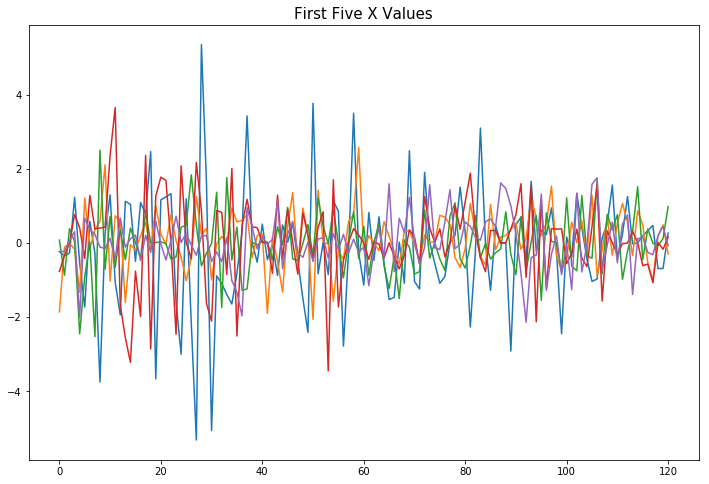

In [181]:
plt.figure(figsize=(12,8))
for i, (x,y) in enumerate(train_loader):
    x_plt = x.cpu().data.numpy()
    x_plt = x_plt.reshape(1,-1)
    plt.plot(x_plt[0], label=str(i))
    if i == 4:
        break
plt.title('First Five X Values', size=15)
plt.show()

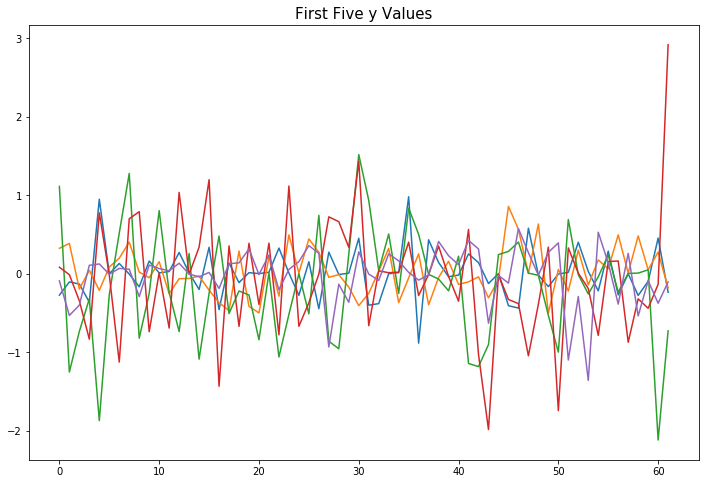

In [182]:
plt.figure(figsize=(12,8))
for i, (x,y) in enumerate(train_loader):
    x_plt = y.cpu().data.numpy()
    x_plt = x_plt.reshape(1,-1)
    plt.plot(x_plt[0], label=str(i))
    if i == 4:
        break
plt.title('First Five y Values', size=15)
plt.show()

In [9]:
nn.init.calculate_gain('leaky_relu', 0.01)

1.4141428569978354

# Define Model

In [205]:
class CNN_1d(nn.Module):
    
    def __init__(self, kernels, filters, hidden):
        super(CNN_1d, self).__init__()
        
        self.cnn = nn.Sequential() # contains convolutional 
        self.reg = nn.Sequential() # layers to process conv features
        self.lin_in = 60 * filters[-1] # change to 60 for 2 maxpool, 40 for 3
        gain = nn.init.calculate_gain('leaky_relu', 0.01)

        # Create Conv layers
        for i, k in enumerate(kernels):
            pad = int((k - 1) / 2)
            if i == 0: # First conv layer
                conv = nn.Conv1d(1, filters[i], k, 1, padding=pad)
            else: # subsequent
                conv = nn.Conv1d(filters[i-1], filters[i], k, 1, pad)
            nn.init.xavier_normal_(conv.weight,gain=gain)
            self.cnn.add_module('conv-' + str(i + 1), conv)
            self.cnn.add_module('lrel' + str(i + 1), nn.LeakyReLU(negative_slope=.01))
            self.cnn.add_module('cbn-'+ str(i +1), nn.BatchNorm1d(filters[i]))
            self.cnn.add_module('cdrp-'+str(i + 1), nn.Dropout(p=0.1)) ##### Comment out for single conv layer
        self.cnn.add_module('mpool', nn.MaxPool1d(2)) # final max pool
        self.cnn.add_module('cnn-drp', nn.Dropout(p=0.1)) ###### Comment out w/ no max pool
        
        # Add input layer to feed forward section
        lin = nn.Linear(self.lin_in, hidden[0])
        nn.init.normal_(lin.weight,std=.05)
        self.reg.add_module('FF-in', lin)
        self.reg.add_module('in-lrel', nn.SELU())
        #self.reg.add_module('rbn-0', nn.BatchNorm1d(1)) ##### SELU is supposed to be self-normalizing 
        self.reg.add_module('in-drp'+ str(i +1), nn.Dropout(p=0.1))
        
        # Create FC/output layers
        for i, k in enumerate(hidden):
            if i < (len(hidden) - 2):
                hid = nn.Linear(k, hidden[i + 1])
                nn.init.normal_(hid.weight,std=.05)
                self.reg.add_module('hid-' + str(i+1), hid)
                self.reg.add_module('h-lrel-' + str(i+1), nn.SELU())
               # self.reg.add_module('rbn-'+ str(i +1), nn.BatchNorm1d(1))
                self.reg.add_module('drp-'+ str(i +1), nn.Dropout(p=0.1,inplace=False))
            elif i == (len(hidden) - 2):
                hid = nn.Linear(k, hidden[i + 1])
                nn.init.normal_(hid.weight,std=.05)
                self.reg.add_module('hid-' + str(i+1), hid)
                self.reg.add_module('h-lrel-' + str(i+1), nn.Tanh())
              #  self.reg.add_module('rbn-'+ str(i +1), nn.BatchNorm1d(1))  ##### This maybe shouldnt have been commented out, try it again (didn't improve)
              #  self.reg.add_module('drp-'+ str(i +1), nn.Dropout(p=0.1,inplace=False))
            elif i == (len(hidden) - 1): # Last layer for output
                hid = nn.Linear(k, 62)
                nn.init.normal_(hid.weight,std=.05)
                self.reg.add_module('out', hid)
                
                
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1,1,self.lin_in)
        x = self.reg(x)
        
        return x
    

Use of SELU, xavier init for conv layers, and normal init with .005 std seems to be doing a good job of getting non-zero predictions.  I also think the use of SELU/tanh with the minmax scaling is also helping with directionality and reasonable magnitude predictions.  Perhaps SELUs ability to output negative values is what matters here.  

Dropout seems to work best at 0.1 with worse predictions and higher and lower levels.  

Trying changes to maxpool, also want to try changing orders of dropout and batchnorm.

### Build Model, Loss, and Optimizer

In [206]:
kernels = [3,3]
filters = [4,4]
hidden = [75,40]

cnn1 = CNN_1d(kernels, filters, hidden)
cnn1 = cnn1.cuda()

loss_w = wmae_loss().cuda()
loss_fnA = mod_mse(l1=0.3).cuda()
loss_fnB = nn.MSELoss().cuda()
opt_alg = torch.optim.RMSprop(cnn1.parameters(), lr=.01)
opt = torch.optim.lr_scheduler.MultiStepLR(opt_alg, milestones=[2,5,7])

#train_wt, test_wt = train_wt.view(-1,1,2), test_wt.view(-1,1,2)
#train_wt, test_wt = train_wt.cuda(), test_wt.cuda()

print(cnn1)

CNN_1d(
  (cnn): Sequential(
    (conv-1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel1): LeakyReLU(negative_slope=0.01)
    (cbn-1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cdrp-1): Dropout(p=0.1, inplace=False)
    (conv-2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel2): LeakyReLU(negative_slope=0.01)
    (cbn-2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cdrp-2): Dropout(p=0.1, inplace=False)
    (mpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (cnn-drp): Dropout(p=0.1, inplace=False)
  )
  (reg): Sequential(
    (FF-in): Linear(in_features=240, out_features=75, bias=True)
    (in-lrel): SELU()
    (in-drp2): Dropout(p=0.1, inplace=False)
    (hid-1): Linear(in_features=75, out_features=40, bias=True)
    (h-lrel-1): Tanh()
    (out): Linear(in_features=40, out_features=62, bias=True)
  )
)


Simpler nets with fewer layers seems to be doing better

### Fit Model


starting epoch  1
	iteration 0 -- 9.352653503417969
	iteration 500 -- 5.1801091782347175
	iteration 1000 -- 5.0508767978532925
	iteration 1500 -- 4.932910975696721
	iteration 2000 -- 4.79184292174172
	iteration 2500 -- 4.742837357466243
	iteration 3000 -- 4.667503085991654
	iteration 3500 -- 4.6132599236504825
	iteration 4000 -- 5.181820982286436
	iteration 4500 -- 5.090639286916856
	iteration 5000 -- 4.979834742353955
	iteration 5500 -- 4.926748246870091
	iteration 6000 -- 4.864741109099275
	iteration 6500 -- 4.77981944435139
	iteration 7000 -- 4.760028699477593
	iteration 7500 -- 4.7032284361452215
	iteration 8000 -- 4.645504742924116
	iteration 8500 -- 4.589953177614137
	iteration 9000 -- 4.551251341738101
	iteration 9500 -- 4.540154073206629
	iteration 10000 -- 4.508825526003504
	iteration 10500 -- 4.472523459819667
	iteration 11000 -- 4.461778488706734
	iteration 11500 -- 4.4369792907370265
	iteration 12000 -- 4.441288525594214
	iteration 12500 -- 4.416102245670539
	iteration 130

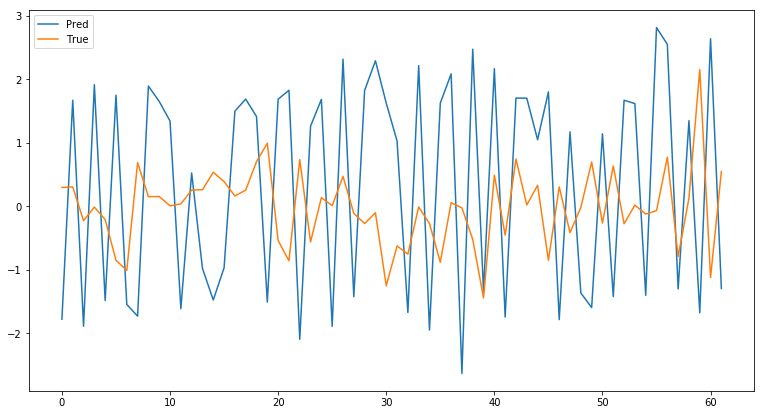

Epoch 1/5, Training Loss: 3.95244, Testing Loss: 3.36881

starting epoch  2
	iteration 0 -- 2.7323546409606934
	iteration 500 -- 3.300907546472169
	iteration 1000 -- 3.1637945271931684
	iteration 1500 -- 3.110570954609362
	iteration 2000 -- 3.1288040006893505
	iteration 2500 -- 3.2430520840808423
	iteration 3000 -- 3.1962234128598013
	iteration 3500 -- 3.1680987021372133
	iteration 4000 -- 3.1591177959199013
	iteration 4500 -- 3.1329336395146608
	iteration 5000 -- 3.1435714115907705
	iteration 5500 -- 3.1082119833792454
	iteration 6000 -- 3.1059616515833506
	iteration 6500 -- 3.0944898761551007
	iteration 7000 -- 3.3949202106750245
	iteration 7500 -- 3.3792088998188863
	iteration 8000 -- 3.3366331828413807
	iteration 8500 -- 3.3099829362723536
	iteration 9000 -- 3.290215364298202
	iteration 9500 -- 3.2659963365040783
	iteration 10000 -- 3.3406164886152587
	iteration 10500 -- 3.3317895052790836
	iteration 11000 -- 3.3120688005513834
	iteration 11500 -- 3.2893638108390464
	iteration 1200

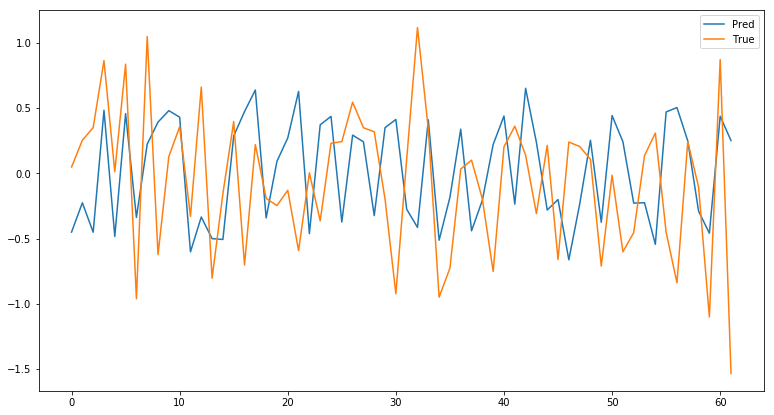

Epoch 2/5, Training Loss: 3.00824, Testing Loss: 2.65531

starting epoch  3
	iteration 0 -- 1.9706807136535645
	iteration 500 -- 2.546873477523674
	iteration 1000 -- 2.4335169374764143
	iteration 1500 -- 2.4385695275586894
	iteration 2000 -- 2.8102967312102436
	iteration 2500 -- 2.7755621836477165
	iteration 3000 -- 2.7829165458381273
	iteration 3500 -- 2.7341156262171267
	iteration 4000 -- 2.706250653993008
	iteration 4500 -- 2.6920913403112605
	iteration 5000 -- 2.6783002504311284
	iteration 5500 -- 2.634498683815977
	iteration 6000 -- 2.6284250793526955
	iteration 6500 -- 2.6133784307019376
	iteration 7000 -- 2.5939047439679674
	iteration 7500 -- 2.630733201216418
	iteration 8000 -- 2.6008431524757207
	iteration 8500 -- 2.6157945590066345
	iteration 9000 -- 2.7381494432247395
	iteration 9500 -- 2.945318453096237
	iteration 10000 -- 2.9366495113213795
	iteration 10500 -- 2.9206546059552516
	iteration 11000 -- 2.8955252398963234
	iteration 11500 -- 2.8709838201160918
	iteration 12000 

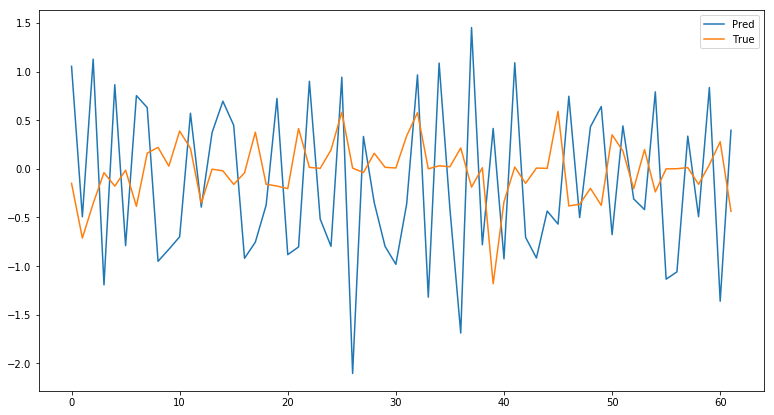

Epoch 3/5, Training Loss: 2.58876, Testing Loss: 2.45973

starting epoch  4
	iteration 0 -- 1.4337157011032104
	iteration 500 -- 2.2928945976579023
	iteration 1000 -- 2.367141657924795
	iteration 1500 -- 2.3578140648859964
	iteration 2000 -- 2.2938936043536287
	iteration 2500 -- 2.345084465953742
	iteration 3000 -- 2.355380516058602
	iteration 3500 -- 2.333363983323662
	iteration 4000 -- 2.3239626753586466
	iteration 4500 -- 2.303563814743496
	iteration 5000 -- 2.349618168818524
	iteration 5500 -- 2.3552605059987264
	iteration 6000 -- 2.329286779369678
	iteration 6500 -- 2.3208854661925247
	iteration 7000 -- 2.3192101628537554
	iteration 7500 -- 2.3116274721033494
	iteration 8000 -- 2.2979027517042137
	iteration 8500 -- 2.284941134056951
	iteration 9000 -- 2.3933588443875458
	iteration 9500 -- 2.394209881651817
	iteration 10000 -- 2.3734949884319554
	iteration 10500 -- 2.3925226564754043
	iteration 11000 -- 2.380291893247929
	iteration 11500 -- 2.369376429956111
	iteration 12000 -- 2.3

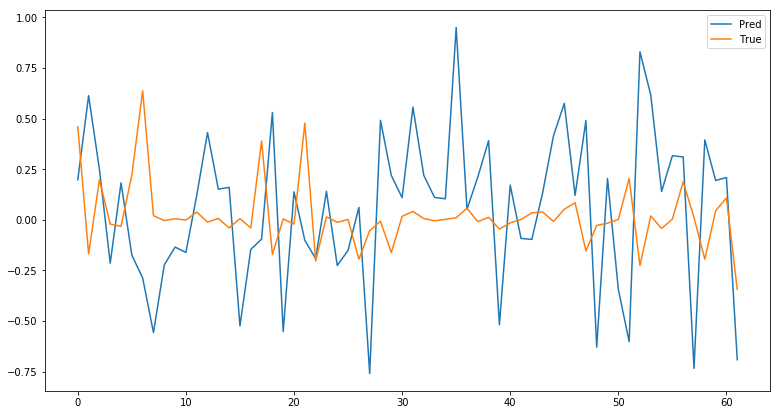

Epoch 4/5, Training Loss: 2.44260, Testing Loss: 2.35102

starting epoch  5
	iteration 0 -- 1.5987153053283691
	iteration 500 -- 2.2366826567583216
	iteration 1000 -- 2.0785819098249183
	iteration 1500 -- 2.1725179157520755
	iteration 2000 -- 2.1406582137276566
	iteration 2500 -- 2.1263254272346734
	iteration 3000 -- 2.160984948063961
	iteration 3500 -- 2.187290494568312
	iteration 4000 -- 2.235746840958713
	iteration 4500 -- 2.2499716514694614
	iteration 5000 -- 2.215133820103779
	iteration 5500 -- 2.2417999645879627
	iteration 6000 -- 2.22173646425152
	iteration 6500 -- 2.219803315990614
	iteration 7000 -- 2.2054679584390793
	iteration 7500 -- 2.1999066557276805
	iteration 8000 -- 2.189031016054101
	iteration 8500 -- 2.1701227671475203
	iteration 9000 -- 2.384576478907432
	iteration 9500 -- 2.3536263103673813
	iteration 10000 -- 2.3337320143098226
	iteration 10500 -- 2.315951997167144
	iteration 11000 -- 2.3110332870042365
	iteration 11500 -- 2.308583661850385
	iteration 12000 -- 2.3

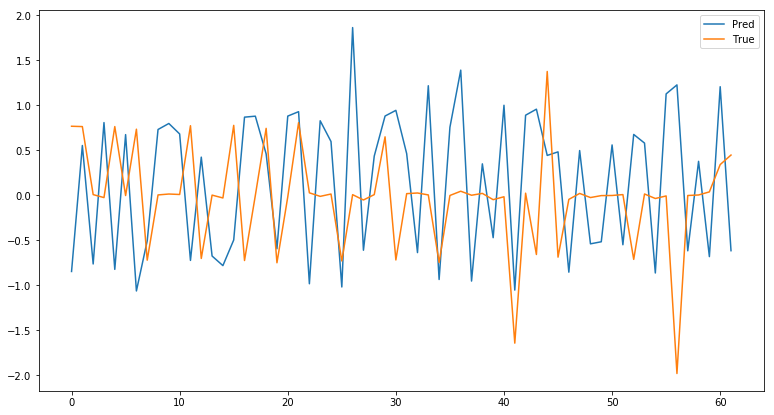

Epoch 5/5, Training Loss: 2.25707, Testing Loss: 2.36330


In [208]:
mod = train_model(cnn1, loss_fnA, opt_alg, opt)

mod.fit(train_loader, test_loader, num_epochs=5)

Improvement: set aside a sample to plot each time instead of whatever happens to be last

# Diagnostics

In [209]:
test, test2 = predict(cnn1, test_loader, True)
test = test.reshape(-1,1,62)
test2 = test2.reshape(-1,1,60)

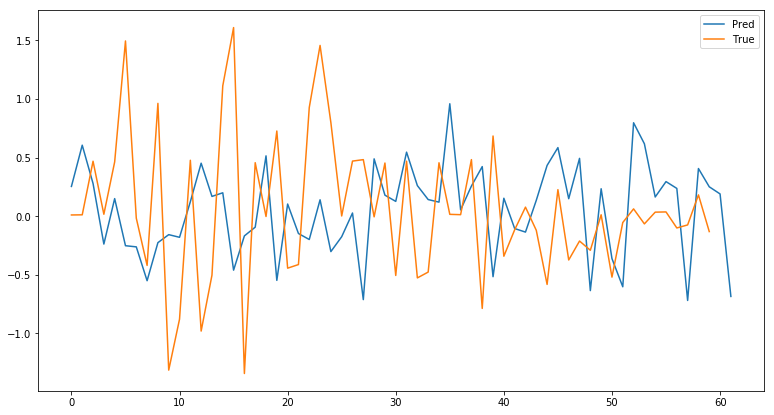

In [224]:
ind = 20

plt.figure(figsize=(13,7))
plt.plot(test[ind][0], label='Pred')
plt.plot(test2[ind][0], label='True')
plt.legend()
plt.show()

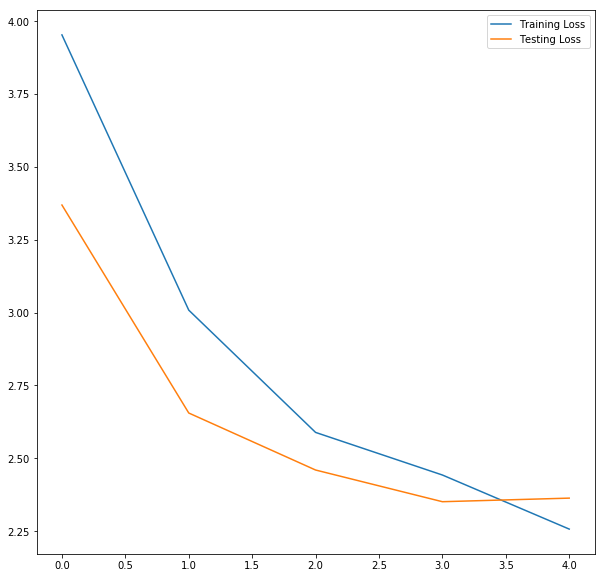

In [211]:
tot_train = mod._losses('train_loss')
tot_eval = mod._losses('eval_loss')
plt.figure(figsize=(10,10))
plt.plot(tot_train, label='Training Loss')
plt.plot(tot_eval, label='Testing Loss')
plt.legend()
plt.show()

No dropout causing testing loss to be low?

In [212]:
hid_1_w = cnn1.state_dict()['reg.FF-in.weight'].cpu()

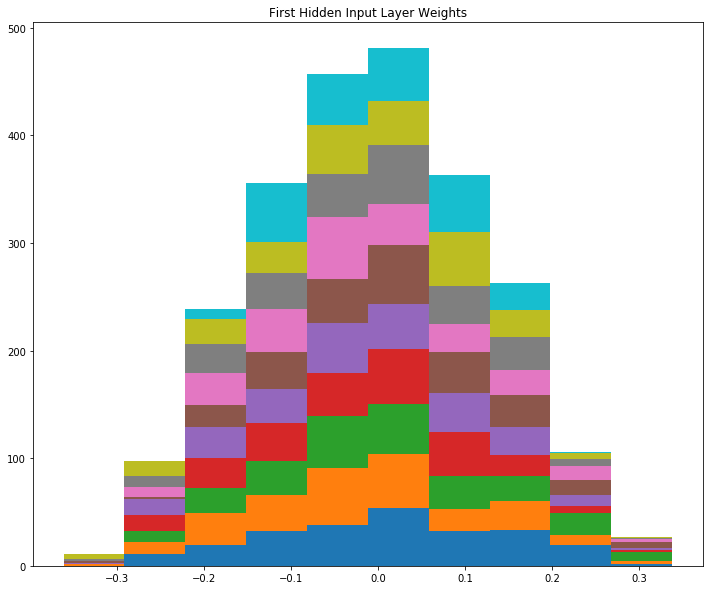

In [213]:
plt.figure(figsize=(12,10))
plt.hist(hid_1_w[15:25], stacked=True)
plt.title('First Hidden Input Layer Weights')
plt.show()

In [214]:
reg_hid3_w = cnn1.state_dict()['reg.out.weight'].cpu()

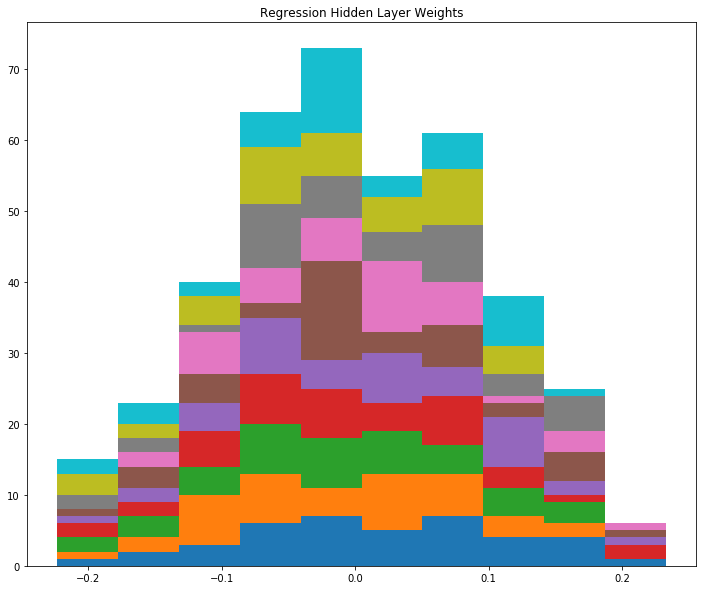

In [215]:
plt.figure(figsize=(12,10))
plt.hist(reg_hid3_w[15:25], stacked=True)
plt.title('Regression Hidden Layer Weights')
plt.show()

In [216]:
reg_hid5_w = cnn1.state_dict()['reg.hid-1.weight'].cpu()

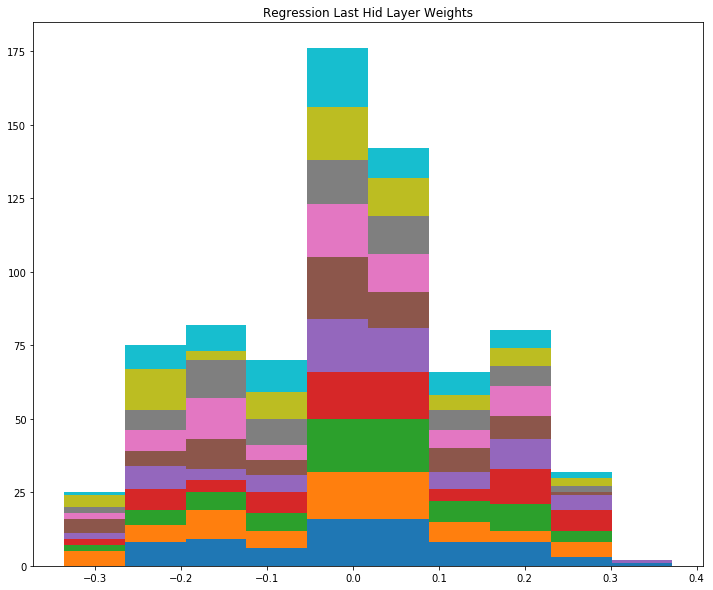

In [217]:
plt.figure(figsize=(12,10))
plt.hist(reg_hid5_w[15:25], stacked=True)
plt.title('Regression Last Hid Layer Weights')
plt.show()

In [218]:
reg_out_w = cnn1.state_dict()['reg.out.weight'].cpu()

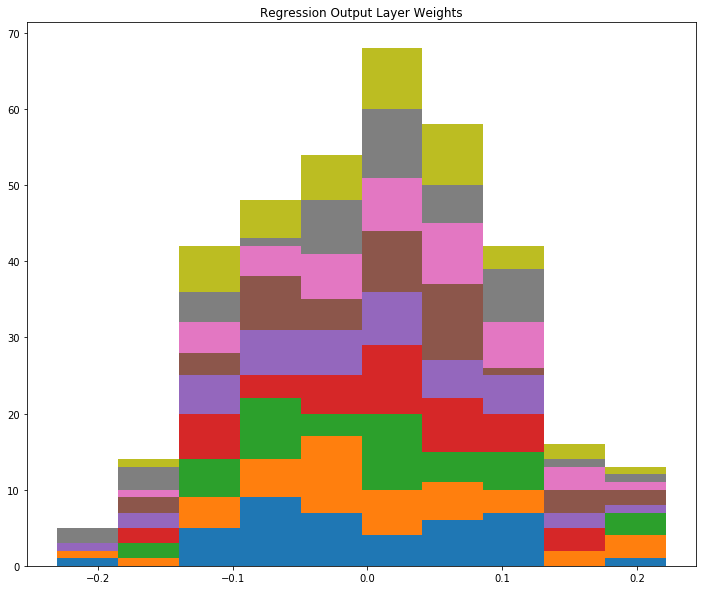

In [219]:
plt.figure(figsize=(12,10))
plt.hist(reg_out_w[1:10], stacked=True)
plt.title('Regression Output Layer Weights')
plt.show()

In [ ]:
#cnn_3 = cnn1.state_dict()['cnn.conv-1.weight'].cpu()

# Submission File

In [185]:
def make_sub(sub_f, fn):
    sub = data.reverse_trans(y=sub_f)
    sub = sub.reshape(-1,1)
   # print(sub.shape)
    win = [i for i in range(1,120001)]
    step = [i for i in range(1,63)]
    rnames = [None] * sub.shape[0]

    ind = 0

    for i in win:
        for k in step:
            name = str(i) + '_' + str(k)
            rnames[ind] = name
            ind += 1

    s = pd.DataFrame(rnames)
    s.columns = ['Id']
    s['Predicted'] = sub
    path = r"C:\Users\rlagr\fin\winton\data\\"
    path = path + fn
    
    s.to_csv(path, index=False)

In [225]:
sub_f = predict(cnn1, sub_load, sub=True)
sub_f = sub_f.reshape(-1,62)
make_sub(sub_f, fn="pytorch_cnn1_small_modMSE2.csv")

# Recycle Bin

In [ ]:
#Training the CNN
num_epochs = 4

#Define the lists to store the results of loss and accuracy

losses = {'train_loss' : [None]*num_epochs , 'eval_loss' : [None]*num_epochs}

#Training
for epoch in range(num_epochs): 
    
    print('starting epoch ', str(epoch + 1))
    iterations = 0
    iter_loss = 0.0
    
    cnn1.train()
    for i, (x,y) in enumerate(train_loader):

        true = y
      #  x = x.cuda(non_blocking=True)

        opt_alg.zero_grad()
        
        out = cnn1(x)
        
       # lossA = loss_fnA(out, true)
        loss = loss_fnB(out, true)
       # loss = loss_w(out, true, train_wt[i:i+batch,:,:])
       # loss = lossA + lossB
        
        iter_loss += loss.item()
        loss.backward()
        opt_alg.step()
        opt.step()
        
        iterations += 1
        
        if i % 500 == 0:
            print('\titeration', str(i), '--', str(iter_loss/iterations))
            
       
    losses['train_loss'][epoch] = iter_loss / iterations

    # Test
    cnn1.eval()
    ev_loss = 0.0
    iterations = 0
    
    for i, (x,y) in enumerate(test_loader):
        
        true = y
      #  x = x.cuda(non_blocking=True)
        
        out = cnn1(x)

        loss = loss_fnB(out, true)
        
       # loss = loss_w(out, true, test_wt[i:i+batch,:,:])
       # loss = lossA + lossB
        ev_loss += loss.item()
        
        iterations += 1
    
    if epoch % 1 == 0:
        tst_plt = out.cpu().data.numpy()
        tr_plt = true.cpu().data.numpy()
        tst_plt = tst_plt.reshape(-1,62)
        tr_plt = tr_plt.reshape(-1,62)
        plt.figure(figsize=(13,7))
        plt.plot(tst_plt[0], label="Pred")
        plt.plot(tr_plt[0], label='True')
        plt.legend()
        plt.show()
    
    losses['eval_loss'][epoch] = ev_loss / iterations
  #  mae = mean_absolute_error(out.cpu().data.numpy(), true.cpu().data.numpy())
    
    print ('Epoch {}/{}, Training Loss: {:.5f}, Testing Loss: {:.5f}, Test MAE (plotted)'
           .format(epoch+1, num_epochs, losses['train_loss'][epoch], losses['eval_loss'][epoch]))
    

~ 15 epochs

CNN_1d(
  (cnn): Sequential(
    (conv-1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel1): LeakyReLU(negative_slope=0.01)
    (bn-1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel2): LeakyReLU(negative_slope=0.01)
    (bn-2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-3): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel3): LeakyReLU(negative_slope=0.01)
    (bn-3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-4): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel4): LeakyReLU(negative_slope=0.01)
    (bn-4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-5): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel5): LeakyReLU(negative_slope=0.01)
    (bn-5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-6): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel6): LeakyReLU(negative_slope=0.01)
    (bn-6): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-7): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel7): LeakyReLU(negative_slope=0.01)
    (bn-7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-8): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel8): LeakyReLU(negative_slope=0.01)
    (bn-8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-9): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel9): LeakyReLU(negative_slope=0.01)
    (bn-9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-10): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel10): LeakyReLU(negative_slope=0.01)
    (bn-10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-11): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel11): LeakyReLU(negative_slope=0.01)
    (bn-11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-12): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel12): LeakyReLU(negative_slope=0.01)
    (bn-12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-13): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel13): LeakyReLU(negative_slope=0.01)
    (bn-13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (mpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (reg): Sequential(
    (FF-in): Linear(in_features=3840, out_features=2000, bias=True)
    (in-lrel): LeakyReLU(negative_slope=0.01)
    (in-drp13): Dropout(p=0.25, inplace=False)
    (hid-1): Linear(in_features=2000, out_features=1500, bias=True)
    (h-lrel-1): LeakyReLU(negative_slope=0.01)
    (drp-1): Dropout(p=0.25, inplace=False)
    (hid-2): Linear(in_features=1500, out_features=1000, bias=True)
    (h-lrel-2): LeakyReLU(negative_slope=0.01)
    (drp-2): Dropout(p=0.25, inplace=False)
    (hid-3): Linear(in_features=1000, out_features=500, bias=True)
    (h-lrel-3): LeakyReLU(negative_slope=0.01)
    (drp-3): Dropout(p=0.25, inplace=False)
    (out): Linear(in_features=500, out_features=62, bias=True)
  )
)
